In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
import random
import numpy as np

In [2]:
file_paths = glob.glob('/home/le/capture_classify/data/images/*')
labels = [0 if 'real' in i else 1 for i in file_paths ]
usage  = np.random.choice(['train', 'valid'], size = len(file_paths), p = [0.8, 0.2])

df = pd.DataFrame(columns = ['file_path', 'labels', 'usage'], data = zip(file_paths, labels, usage))
df.head()

file_path  labels  usage
0  /home/le/capture_classify/data/images/real       0  train
1  /home/le/capture_classify/data/images/fake       1  train

In [6]:
df.iloc[0, 1]

1

In [ ]:
df.to_csv('../data/data_final.csv', index = False)

In [3]:
df = pd.read_csv('/home/le/capture_classify/data/data_final.csv', index_col = False)

In [4]:
df.head()

file_path  labels  usage
0  /home/le/capture_classify/data/images/real/DL0...       0  train
1  /home/le/capture_classify/data/images/fake/101...       1  train
2  /home/le/capture_classify/data/images/fake/86.jpg       1  train
3  /home/le/capture_classify/data/images/real/id_...       0  valid
4  /home/le/capture_classify/data/images/real/DL0...       0   test

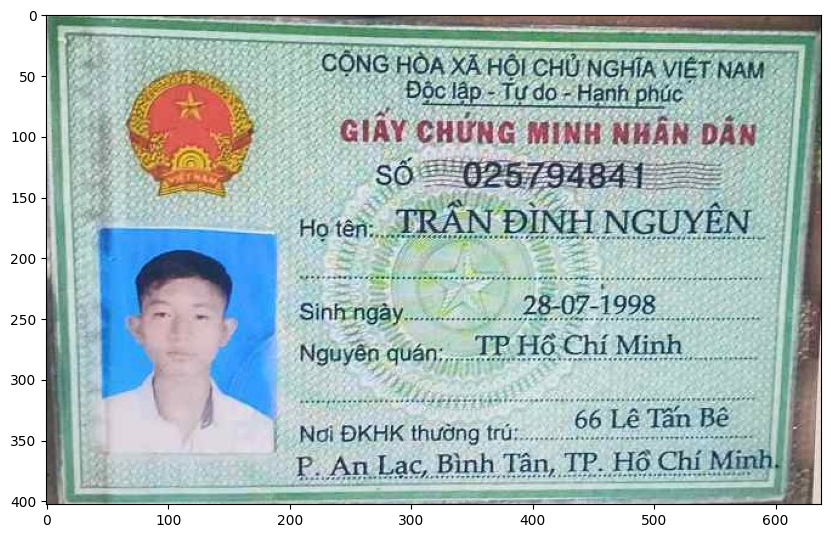

In [4]:
test = df.loc[2].values.tolist() #fake

img = cv2.imread(test[0])[...,::-1]
plt.figure(figsize = (10, 10))
plt.imshow(img)

In [5]:
def laplance_filter(image: np.ndarray, kernel_size: int = 2) -> np.ndarray:
    # Declare the variables we are going to use
    ddepth = cv2.CV_16S

    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Laplace function
    dst = cv2.Laplacian(image_gray, ddepth, ksize=kernel_size)

    # converting back to uint8
    abs_dst = cv2.convertScaleAbs(dst)

    return abs_dst




In [6]:
from typing import Tuple

In [7]:
def increase_constrast(image: np.ndarray, limit: int = 2.0, gridsize: Tuple[int, ...]= (8, 8)) -> np.ndarray:
    
    # converting to LAB color space
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit= limit, tileGridSize= gridsize)
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limage = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_image = cv2.cvtColor(limage, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    result = np.hstack((image, enhanced_image))

    return result, enhanced_image

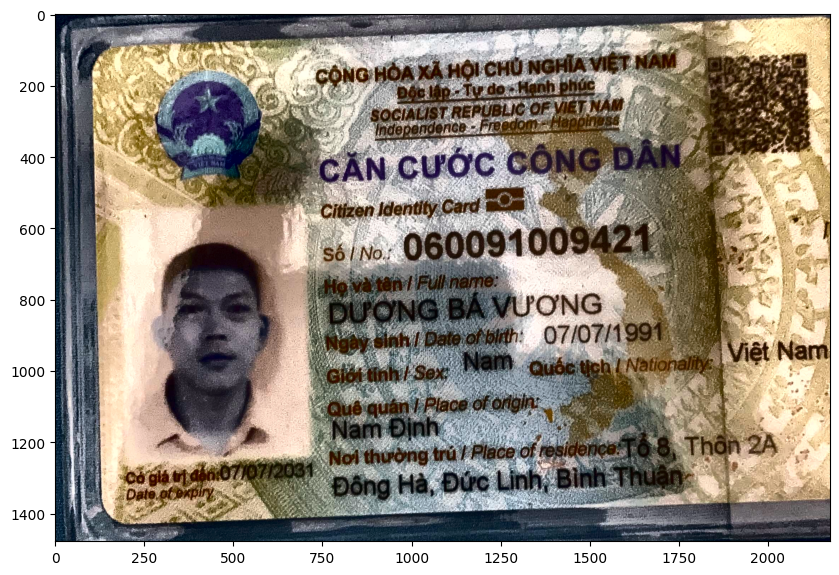

In [10]:
test = df.loc[4].values.tolist() #fake

img = cv2.imread(test[0])
res, _ = increase_constrast(img, limit = 8, gridsize = (4, 4))
plt.figure(figsize = (10, 10))
plt.imshow(_)

In [33]:
test = df.loc[1].values.tolist() #fake

# img = cv2.imread(test[0])
img = cv2.imread('/home/le/capture_classify/data/photo_6145468623251157684_x.jpg')
image, _ = increase_constrast(img, limit = 8, gridsize = (4, 4))
plt.figure(figsize = (10, 10))
plt.imshow(_)

ValueError: too many values to unpack (expected 2)

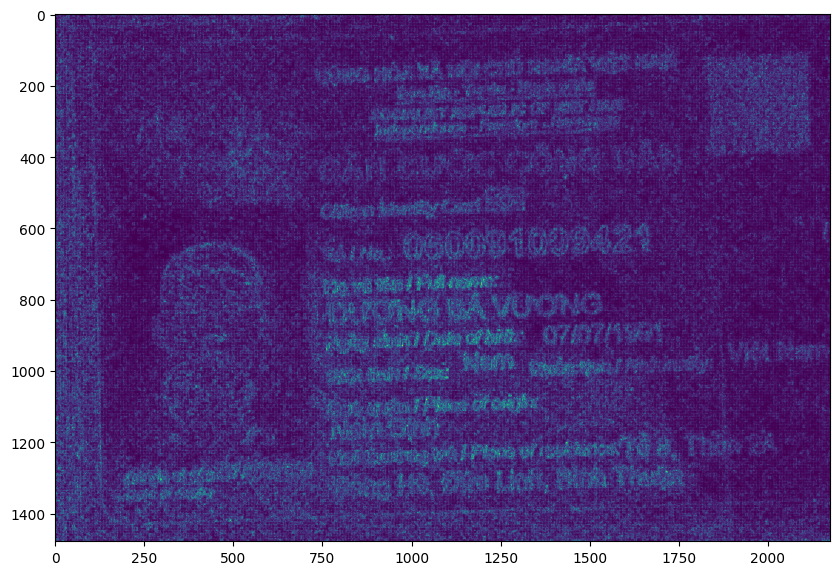

In [16]:
test = df.loc[4].values.tolist() #fake

img = cv2.imread(test[0])
image = laplance_filter(img, kernel_size = 3)
plt.figure(figsize = (10, 10))
plt.imshow(image)

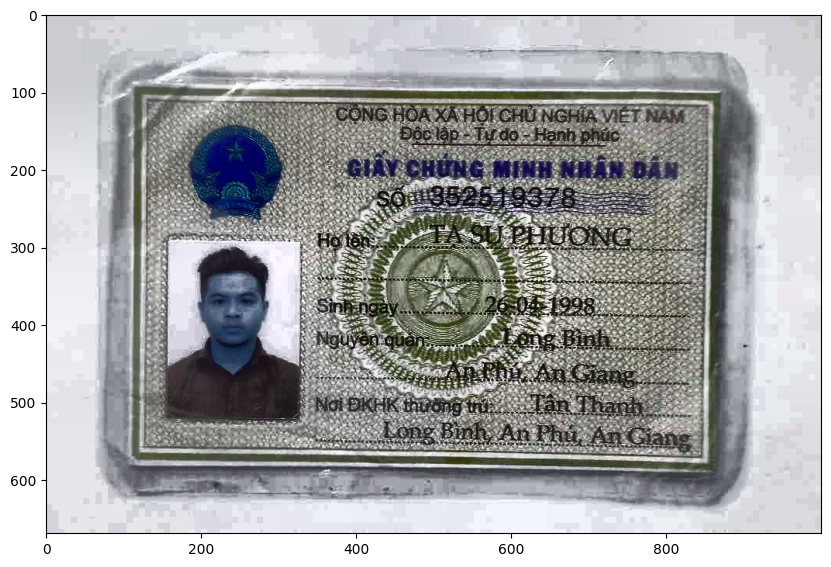

In [13]:
test = df.loc[0].values.tolist() #fake

img = cv2.imread(test[0])
image, _ = increase_constrast(img, limit = 8, gridsize = (4, 4))
plt.figure(figsize = (10, 10))
plt.imshow(_)

inference

In [2]:
import torch
import cv2
import pandas as pd

from dataloader.process import *
from dataloader.transform import transform_val
from models.net import build_model, alex_model
import matplotlib.pyplot as plt

In [3]:
input_size = [640, 640]
method = 'contrast'
num_classes = 2
device = 'cuda'
classes = ['real', 'fake']

In [4]:
# Load the trained model.
# model = build_model(num_classes)
model = alex_model(num_classes)
checkpoint = torch.load('../outputs/model_pretrained_alex.pth')
print('---------------Loading trained model weights----------------')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Using cache found in /home/le/.cache/torch/hub/pytorch_vision_v0.6.0


---------------Loading trained model weights----------------


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Text(0.5, 1.0, 'GT: fake -- Pred: fake')

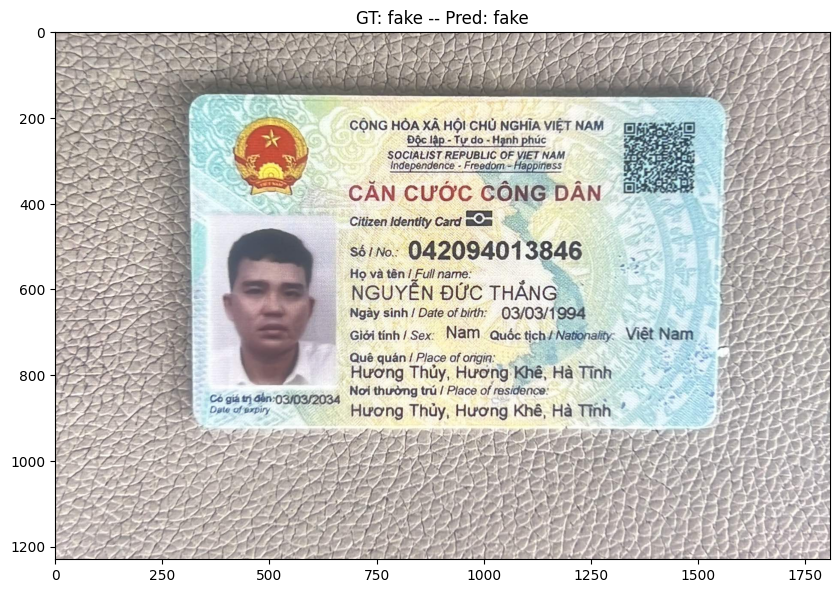

In [24]:
df = pd.read_csv('../data/data_final.csv')


# fig, axes = plt.subplot(nrows = 4, ncols = 5, figsize = (20, 60))
# test = df.loc[i].values.tolist() #fake
# img0 = read_image(test[0])
img0 = cv2.imread('/home/le/capture_classify/data/images/fake/c31.jpg')
img = preprocess_pipeline(img0, input_size, method)
trf = transform_val(method)
img = trf(img)
img = torch.unsqueeze(img, 0)
img = img.to(device)

#predict:
out = model(img)
out = out.cpu().data.numpy()
pred_class_name = classes[np.argmax(out[0])]


plt.figure(figsize = (10, 10))
plt.imshow(img0[...,::-1])
# plt.title(f'GT: {classes[test[1]]} -- Pred: {pred_class_name}')
plt.title(f'GT: fake -- Pred: {pred_class_name}')


Text(0.5, 1.0, 'Pred: real')

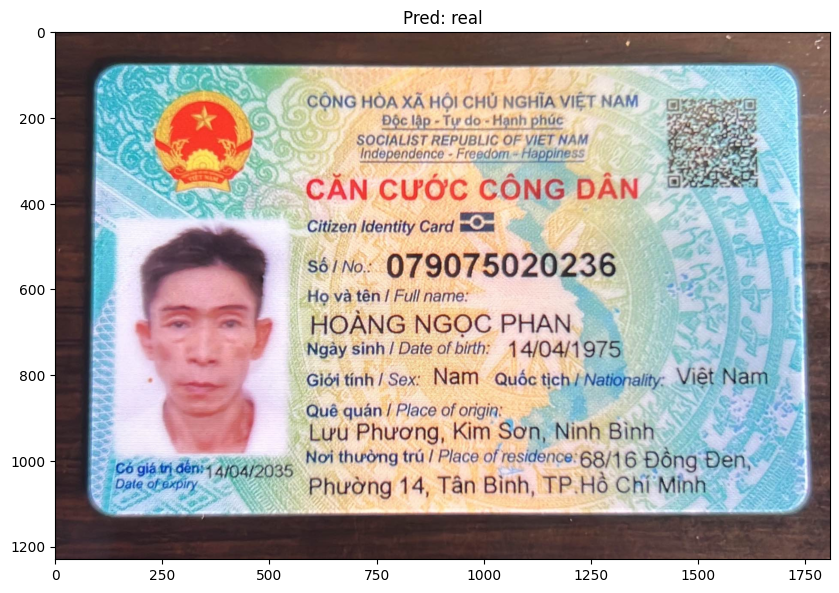

In [44]:
# out = model(img)
# out = out.cpu().data.numpy()
# pred_class_name = classes[np.argmax(out[0])]

plt.figure(figsize = (10, 10))
plt.imshow(img0[...,::-1])
# plt.title(f'GT: {classes[test[1]]} -- Pred: {pred_class_name}')
plt.title(f'Pred: {pred_class_name}')

# print(pred_class_name)